***OCR에 넣기전, 전처리 과정***

+ *배경을 제거하고 전경(여기선 영수증)만 남기기 위한 작업*

---

*오프라인 영수증은 배경(밝은색), 영수증자체는 흰색, 글씨는 검은색인 경우가 일반적*

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### 1. Settings

In [2]:
import os
import sys

base_dir = "/content/gdrive/MyDrive/Workspace/Colab"
sys.path.append(base_dir)

src_dir = os.path.join(base_dir, "ocr")
%cd $src_dir

/content/gdrive/MyDrive/Workspace/Colab/ocr


In [3]:
!pip install -r requirements.txt > /dev/null

In [4]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()
for file_name, file_content in uploaded.items():
    print(f"File name: {file_name}")

image_files = list(uploaded.keys())

Saving Offline.jpg to Offline.jpg
File name: Offline.jpg


### 2. 배경 제거 관련 확인

In [5]:
import cv2
import matplotlib.pyplot as plt
import imutils
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours

In [6]:
image = cv2.imread(image_files[0])

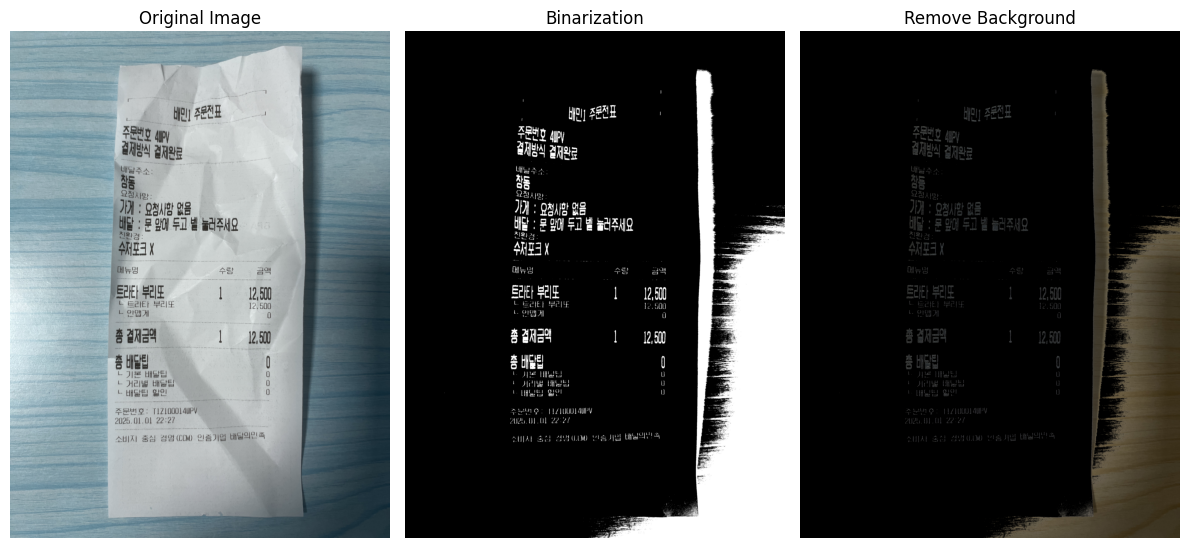

In [34]:
# grayscale 변환
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 이진화 (반전, 보통 글씨가 검은색이고, 영수증이나 주변은 밝기에)
_, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

# 배경 제거 (글씨만 남기기)
background_removed = cv2.bitwise_and(image, image, mask=binary)


plt.figure(figsize=(12, 6))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# 이진화 이미지
plt.subplot(1, 3, 2)
plt.title('Binarization')
plt.imshow(binary, cmap='gray')
plt.axis('off')

# 배경 제거 이미지
plt.subplot(1, 3, 3)
plt.title('Remove Background')
plt.imshow(cv2.cvtColor(background_removed, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

*배경을 제거하기 위한 확인 1*

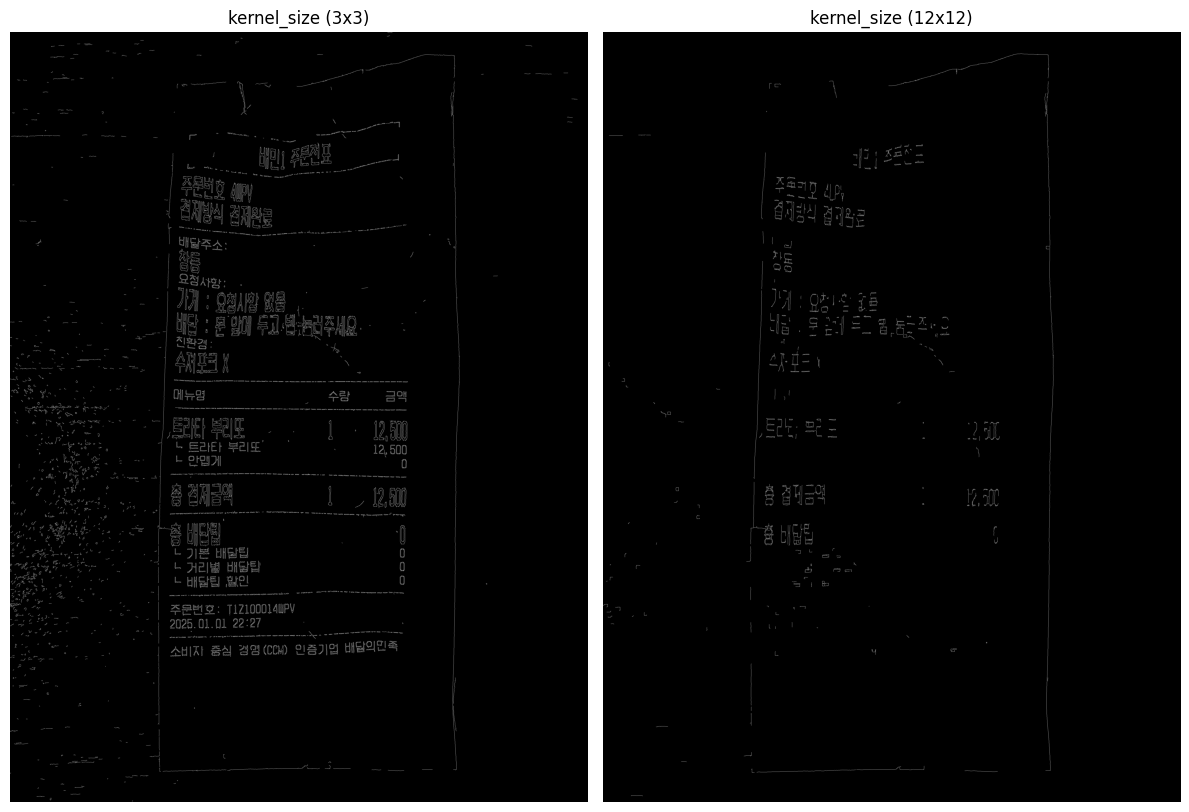

In [107]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 노이즈 제거
kernel_size = (3,3)
blurred = cv2.GaussianBlur(gray, kernel_size, 0)

# 밝은 영역 확장 (직사각형 커널 사용)
rect_kernel_3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dilated_3 = cv2.dilate(blurred, rect_kernel_3)

rect_kernel_12 = cv2.getStructuringElement(cv2.MORPH_RECT, (12,12))
dilated_12 = cv2.dilate(blurred, rect_kernel_12)

# 엣지 검출 (Sobel 연산자가 작을수록 경계선에 민감한 것으로 확인)
edged_3 = cv2.Canny(dilated_3, 50, 100, apertureSize=3)
edged_12 = cv2.Canny(dilated_12, 50, 100, apertureSize=3)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('kernel_size (3x3)')
plt.imshow(cv2.cvtColor(edged_3, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title('kernel_size (12x12)')
plt.imshow(cv2.cvtColor(edged_12, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

*영수증같이 주변부와 비슷한 색상을 가질 경우엔 `Canny 검출에서 apertureSize`를 작게해야 엣지에 더 민감한 듯*

*이미지별 튜닝값이 달라서, 못쓸듯*

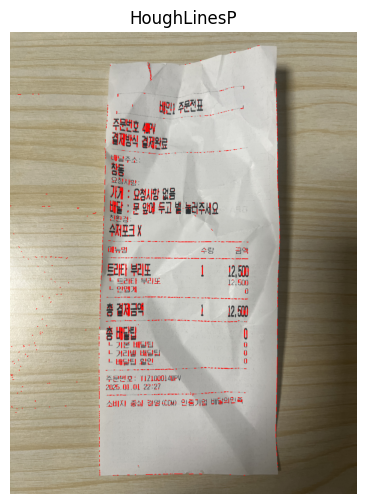

In [91]:
import numpy as np

# 확률 허프 변환
minLineLength = 30  # 선의 최소 길이 (이 값보다 작으면, 무시)
maxLineGap = 5  # 두 선분이 연결될 수 있는 최대 간격 (이 값보다 작으면, 하나의 선으로 간주)

lines = cv2.HoughLinesP(edged_3, 1, np.pi/360, 100, minLineLength, maxLineGap)

image1 = image.copy()
for i in range(len(lines)):
    for x1, y1, x2, y2 in lines[i]:
        cv2.line(image1, (x1, y1), (x2, y2), (0, 0, 255), 3)


plt.figure(figsize=(6, 6))

plt.title('HoughLinesP')
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

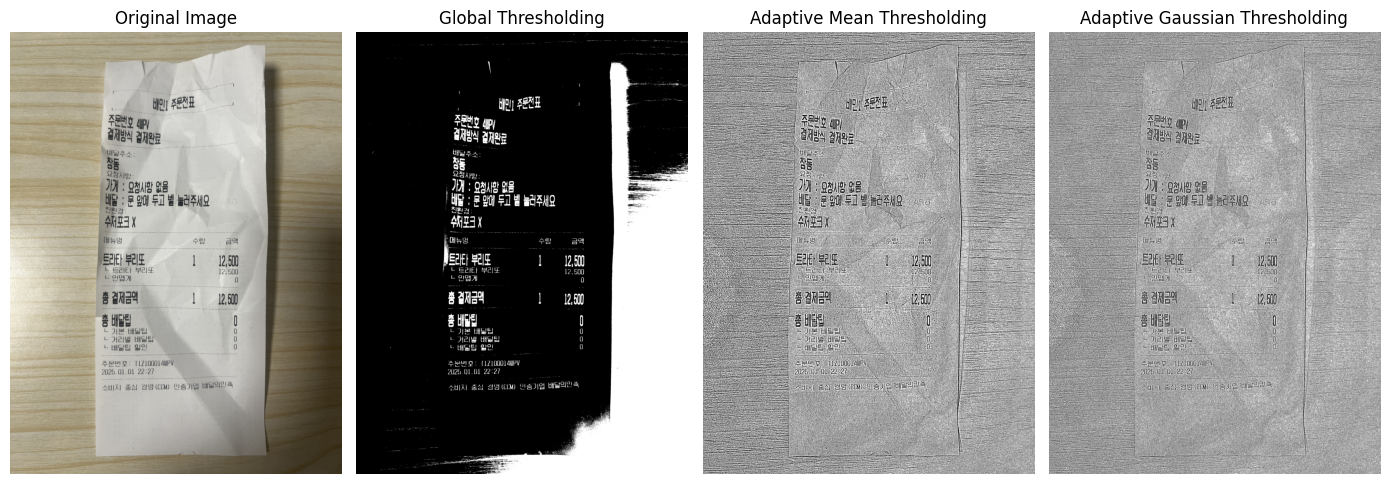

In [77]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 1. Global Thresholding 적용
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 2. Adaptive Mean Thresholding 적용
adaptive_mean = cv2.adaptiveThreshold(gray, 255,
                              cv2.ADAPTIVE_THRESH_MEAN_C,
                              cv2.THRESH_BINARY,
                              blockSize=11, C=2)

# 3. Adaptive Gaussian Thresholding 적용
adaptive_gaussian = cv2.adaptiveThreshold(gray, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY,
                                          blockSize=11, C=2)


plt.figure(figsize=(14, 7))

plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Global Thresholding")
plt.imshow(binary, cmap='gray')
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Adaptive Mean Thresholding")
plt.imshow(adaptive_mean, cmap='gray')
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("Adaptive Gaussian Thresholding")
plt.imshow(adaptive_gaussian, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()

*확실히, 영수증(오프라인)의 경우에는 조명 조건이 비균일한 경우가 많기에 고정된 임계값은 별로*

*지역별로, 임계값을 적용하는 Adaptive가 적절해보임*

---

### 3. 그림자 영역 제거 관련 확인

In [68]:
image_h, image_w = image.shape[:2]
print(image_h, image_w)

4032 3024


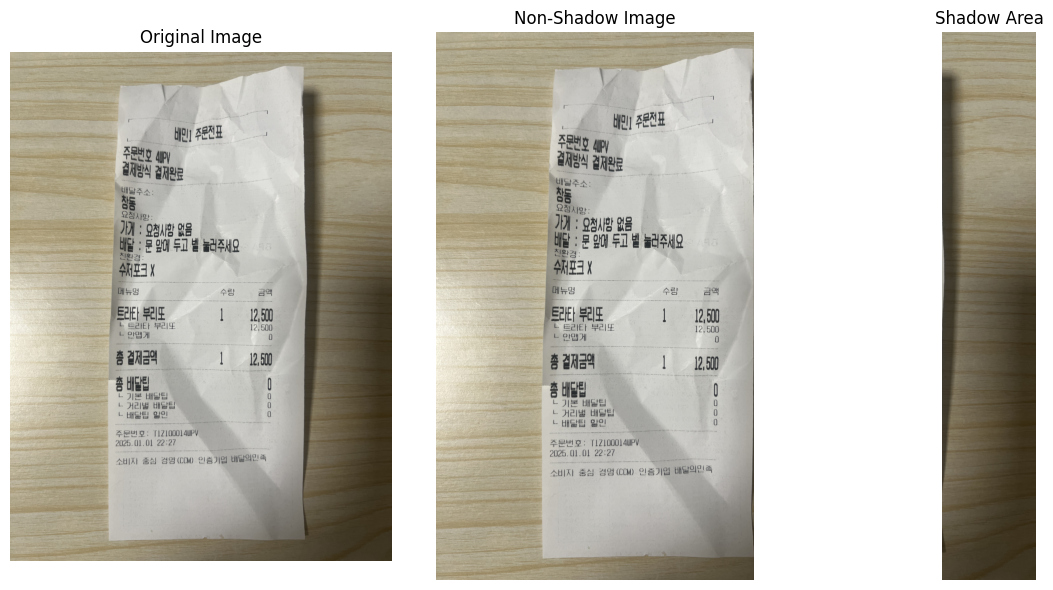

In [93]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

# 수직 히스토그램 계산
vertical_histogram = np.mean(blurred, axis=0)      # 각 열의 평균 밝기 계산
threshold = np.percentile(vertical_histogram, 10)  # 밝기 하위 10%를 그림자로 간주
shadow_mask = vertical_histogram < threshold

# 그림자 영역 탐지 (좌우 경계 찾기)
shadow_columns = np.where(shadow_mask)[0]

if len(shadow_columns) > 0:
    left_bound = shadow_columns[0]    # 그림자 영역의 시작 열
    right_bound = shadow_columns[-1]  # 그림자 영역의 끝 열
else:
    left_bound, right_bound = 0, image.shape[1]  # 그림자 영역이 없는경우, 전체 이미지

# 그림자가 아닌 영역 crop
non_shadow_image = np.hstack((image[:, :left_bound], image[:, right_bound:]))

shadow_image = image[:, left_bound:right_bound]

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title('Non-Shadow Image')
plt.imshow(cv2.cvtColor(non_shadow_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title('Shadow Area')
plt.imshow(cv2.cvtColor(shadow_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

*그림자를 먼저 제거하는 것이 유리*

+ *수직 히스토그램 기반, 그림자 제거 논문 일부 참조*

+ *그림자는 일부 영역에 집중되는 경향이 있고, 특정 열에서만 밝기가 낮은 구간을 찾아내면 됨*

---

### 4. 글자 제거

+ *윤곽선 검출을 더 용이하게 할 수 있을까해서*

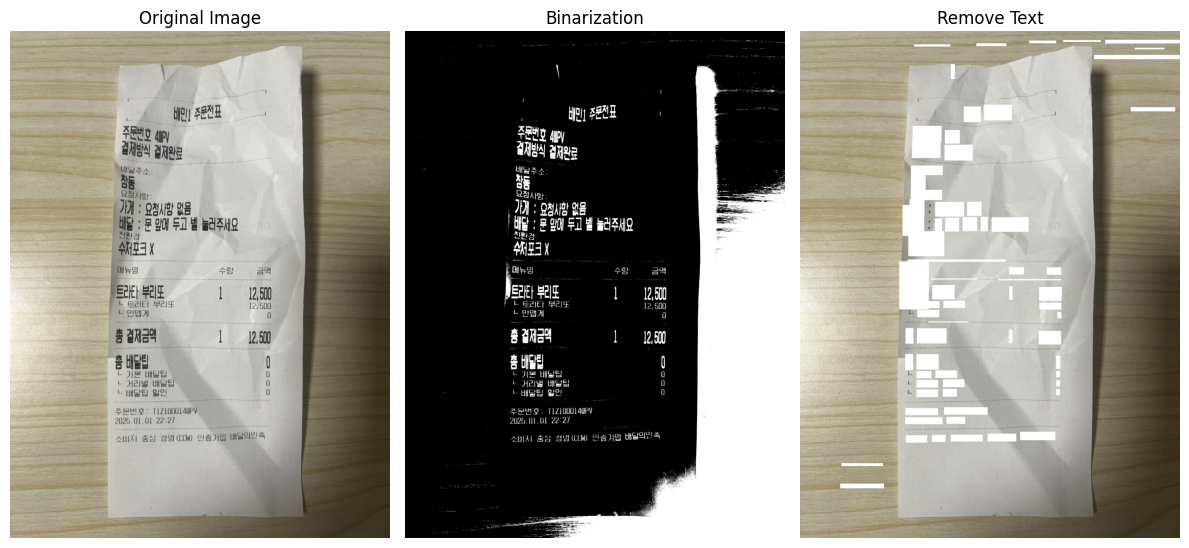

In [136]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 글자를 연결하는 용도 (팽창 후 침식) (가로로 긴 텍스트영역이기에 해당 커널 사용)
close_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
close = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, close_kernel, iterations=1)

# 검은색 영역 확장 (현재 글자가 검은색, 수평 확장)
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
dilate = cv2.dilate(close, rect_kernel, iterations=1)

# 윤곽선 찾기
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# 윤곽선 기반, 직사각형 그리기
image_copy = image.copy()

for c in cnts:

    area = cv2.contourArea(c)
    # 텍스트의 크기에 해당하는 영역
    if area > 1000 and area < 50000:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 255, 255), -1)  # 흰색으로 채움


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Binarization')
plt.imshow(binary, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Remove Text')
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

*최종 목표: 윤곽선 검출이긴 한데,,,*